# IV. Uploading the best model and algorithm creation: detect humans and dogs!

In this notebook, I will use the best model created usging VGG16 along with a human face detector to create an algorithm to classify humans and dogs as follows:

* First obtain an algorithm to detect human faces
* Then create a dog detector
* Combine them and create an algorithm
* Test if it works.... Surprise!

### 0.Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# We start by importing libraries
import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict

import torch
from torch import nn, optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import os


In [3]:
!pip3 install torch torchvision


In [4]:
import PIL
print(PIL.PILLOW_VERSION)

4.1.1


In [5]:
!apt-get install


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [6]:
# Downloading the dog and human dataset
from IPython.display import clear_output
!wget -cq -O dogImages.zip https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget -cq -O lfw.tgz http://vis-www.cs.umass.edu/lfw/lfw.tgz
clear_output()  
print("Downloaded Successfully")

Downloaded Successfully


In [7]:
# Extractting the datasets
!unzip -n dogImages.zip
!tar -xvzf lfw.tgz
clear_output()
print("Extracted Successfully")

Extracted Successfully


In [8]:
# Downloading the pre-trained face detector
import os
if not os.path.isdir('haarcascades'):
    os.mkdir('haarcascades')
!wget -cq -O haarcascades/haarcascade_frontalface_alt.xml https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-dog-classification/haarcascades/haarcascade_frontalface_alt.xml
clear_output()
print("Downloaded Successfully")

Downloaded Successfully


### 1.Prepare images for classification

In [0]:
#The following code will help us when dealing with images to be used in different classification models#
#from PIL import Image
#import torchvision.transforms as transforms
#from torch.autograd import Variable

def process_image_to_tensor(image):

    # define transforms for the training data and testing data
    prediction_transforms = transforms.Compose([transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    
    img_pil = Image.open( image ).convert('RGB')
    img_tensor = prediction_transforms( img_pil )[:3,:,:].unsqueeze(0)
    
    return img_tensor


# helper function for un-normalizing an image  - from STYLE TRANSFER exercise
# and converting it from a Tensor image to a NumPy image for display
def image_convert(tensor):
    """ This is to display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

#### 1.1 Specify Directories

In [0]:
# Specify directories
data_dir = 'dogImages'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# Batch size
batch_size = 20
# For faster computation, setting num_workers
num_workers = 0

# Transforms for the training, validation, and testing sets
data_transforms = {
    'train'      : transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),

    'valid'      : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])]),
    'test'       : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
}

# Loading the datasets with ImageFolder
image_datasets = {
    'train'  : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid'  : datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test'   : datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Using the image datasets and the trainforms to define dataloaders
loaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size = 32, shuffle=True, num_workers = num_workers),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size = 16),
    'test'  : torch.utils.data.DataLoader(image_datasets['test'], batch_size = 16)}

In [12]:
#Find out the number of images for each category
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [13]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Is GPU available: ', 'Yes' if torch.cuda.is_available() else 'No')
# check if CUDA is available
use_cuda = torch.cuda.is_available()

Is GPU available:  Yes


### 2 Upload best model the model

Here we upload the best model we obtained from training a classifier using VGG16. The model was saved in the previous file.

Now we upload it and use it for our algorithm. 

In [0]:
checkpoint = torch.load('checkpoint.pth')
model_transfer2 = models.vgg16(pretrained=True)
for param in model_transfer2.parameters():
    param.requires_grad = False
model_transfer2.classifier = checkpoint["classifier"]
model_transfer2.load_state_dict(checkpoint["state_dict"])

In [34]:
print("Our model: \n\n", model_transfer2, '\n')
print("The state dict keys: \n\n", model_transfer2.state_dict().keys())

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

### 3.Building an algorithm to identify humans and dogs

- if a dog is detected in the image, return the predicted breed.
- if a human is detected in the image, return the resembling dog breed.
- if neither is detected in the image, provide output - that indicates an error.

#### 3.1 Detecting Human faces

In this section, we use OpenCV's implementation of Haar feature-based cascade classifiers to detect human faces in images.


Number of faces detected: 1


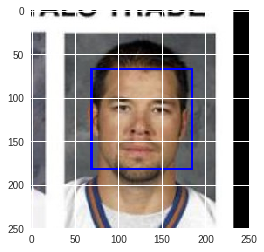

In [35]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

#### 3.1.1 Human face detector 

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

#### 3.2 Assess Human face detector

Number of faces detected: 1


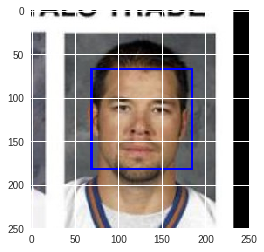

In [60]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [19]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

humans = 0
dogs = 0
for il, (human, dog) in enumerate(zip(human_files_short, dog_files_short)):
  if face_detector(human):
    humans += 1
  if face_detector(dog):
    dogs += 1

print("Human detection accuracy: {}%".format(100. * float(humans) / len(human_files_short)))
print("Dogs detected as human: {}%".format(100. * float(dogs) / len(dog_files_short)))

Human detection accuracy: 99.0%
Dogs detected as human: 9.0%


#### 3.2 Dog Detector


In [0]:
'''The following code will help us when dealing with images to be used in different classification models'''

def process_image_to_tensor(image):

    # define transforms for the training data and testing data
    prediction_transforms = transforms.Compose([transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    
    img_pil = Image.open( image ).convert('RGB')
    img_tensor = prediction_transforms( img_pil )[:3,:,:].unsqueeze(0)
    
    return img_tensor


# helper function for un-normalizing an image  - from STYLE TRANSFER exercise
# and converting it from a Tensor image to a NumPy image for display
def image_convert(tensor):
    """ This is to display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [0]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [39]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Is GPU available: ', 'Yes' if torch.cuda.is_available() else 'No')
VGG16 = VGG16.to(device)

Is GPU available:  Yes


In [0]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Opening an image
    image = Image.open(img_path)
   
    # Preprocessing transforms
    preprocess_transforms = transforms.Compose([transforms.Resize(255),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])])
    
    # Pre-process the image
    image = preprocess_transforms(image)
    
    # Move the tensor to the device
    image = image.to(device)
    
    image = image.unsqueeze(0)
    
    pred = VGG16(image)
    
    # Extract the index of max element
    pred = pred.data.argmax()  
    
    return pred # predicted class index

torch.Size([1, 3, 224, 224])


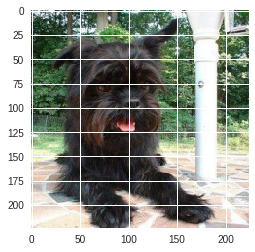

In [49]:
test_dog_image = 'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'
test_tensor = process_image_to_tensor( test_dog_image )
print(test_tensor.shape)
plt.imshow(image_convert(test_tensor))

In [52]:
print("predicted class id : ", VGG16_predict( test_dog_image ))

predicted class id :  tensor(252, device='cuda:0')


#### 3.2.1 Assess Dog detector

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    pred_idx = VGG16_predict(img_path)
    # Return true when pred_idx is between 151 & <=268
    return ((pred_idx <= 268) & (pred_idx >= 151))

In [54]:
dog_detector(test_dog_image)


tensor(1, device='cuda:0', dtype=torch.uint8)

In [55]:
# Test the performance of the dog_detector function
# on the images in human_files_short and dog_files_short.
humans, dogs = 0, 0
for il, (human, dog) in enumerate(zip(human_files_short, dog_files_short)):
  if dog_detector(human):
    humans += 1
  if dog_detector(dog):
    dogs += 1

print("Humans detected as dog: {}%".format(100. * float(humans) / len(human_files_short)))
print("Dog Detection Accuracy: {}%".format(100. * float(dogs) / len(dog_files_short)))

Humans detected as dog: 0.0%
Dog Detection Accuracy: 100.0%


#### 3.3 Implementing the algorithm

In [0]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_tensor = process_image_to_tensor(img_path)

    # move model inputs to cuda, when is GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = model_transfer2(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]


def display_image(img_path, title="Title"):
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()

In [57]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Is GPU available: ', 'Yes' if torch.cuda.is_available() else 'No')
# check if CUDA is available
use_cuda = torch.cuda.is_available()

Is GPU available:  Yes


In [0]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    # check if image has juman faces:
    if (face_detector(img_path)):
        print("Hello Human!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title="When our model sees your picture, it predicts the following breed: {}".format(predicted_breed) )
        
        print("You look like a ...")
        print(predicted_breed)
        
    # check if image has dogs:
    elif dog_detector(img_path):
        print("Hello Dog!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title="When our model sees your picture, it predicts the following breed: {}".format(predicted_breed) )
        
        print("Your breed is probably likley ...")
        print(predicted_breed)
    # otherwise
    else:
        print("Oh, we're terribly sorry! We cannot detect any dog or human face in the image.")
        display_image(img_path, title="...")
        print("Try again!")
        
    print("\n")

####3.4 Test the Algorithm

Hello Human!


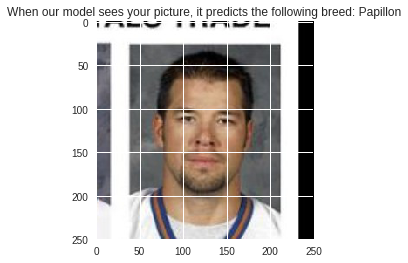

You look like a ...
Papillon


Hello Human!


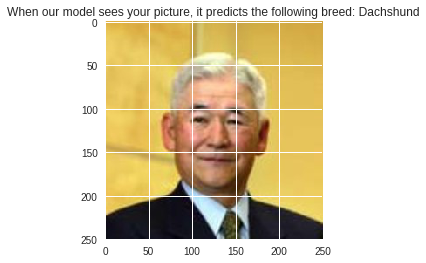

You look like a ...
Dachshund


Hello Human!


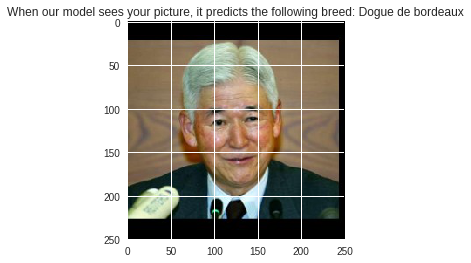

You look like a ...
Dogue de bordeaux


Hello Human!


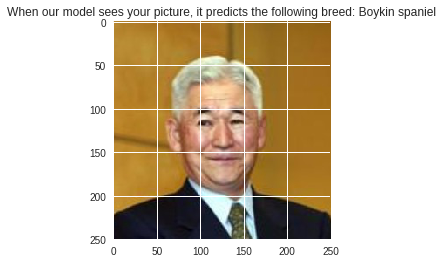

You look like a ...
Boykin spaniel


Hello Human!


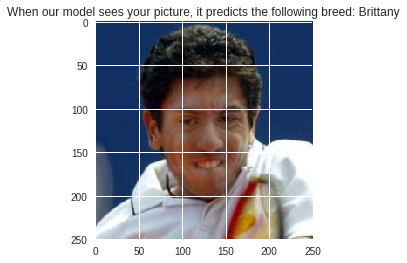

You look like a ...
Brittany


Hello Human!


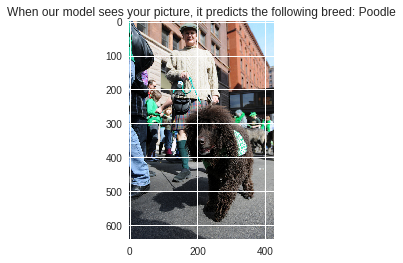

You look like a ...
Poodle


Hello Dog!


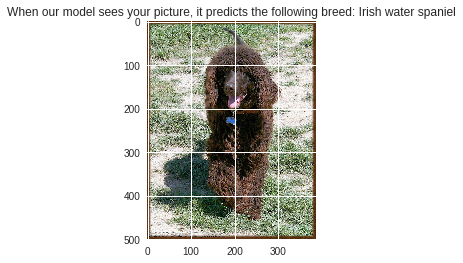

Your breed is probably likley ...
Irish water spaniel


Hello Dog!


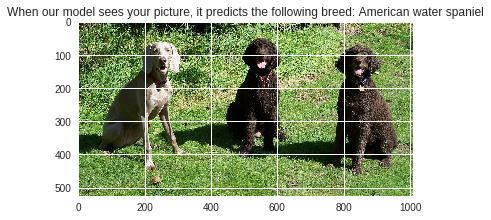

Your breed is probably likley ...
American water spaniel


Hello Dog!


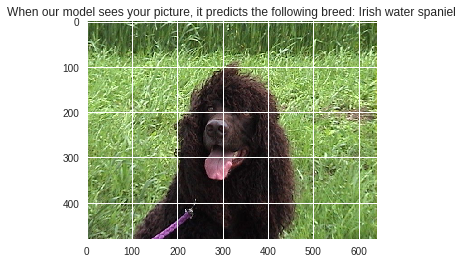

Your breed is probably likley ...
Irish water spaniel


Hello Dog!


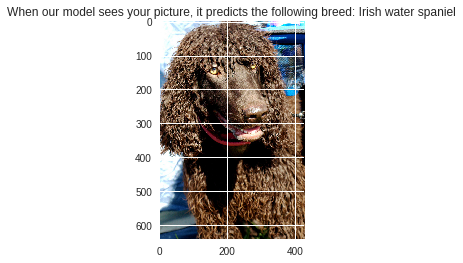

Your breed is probably likley ...
Irish water spaniel




In [59]:
import cv2 
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:5], dog_files[:5])):
    run_app(file)